* Le bi-encodeur prend une paire de phrases en entrée, chacune d'entre elles sera indépendamment intégrée par les modèles BERT.
* L'encodeur croisé prend la même paire de phrases en entrée, effectuant une pleine attention sur la paire de phrases en entrée.

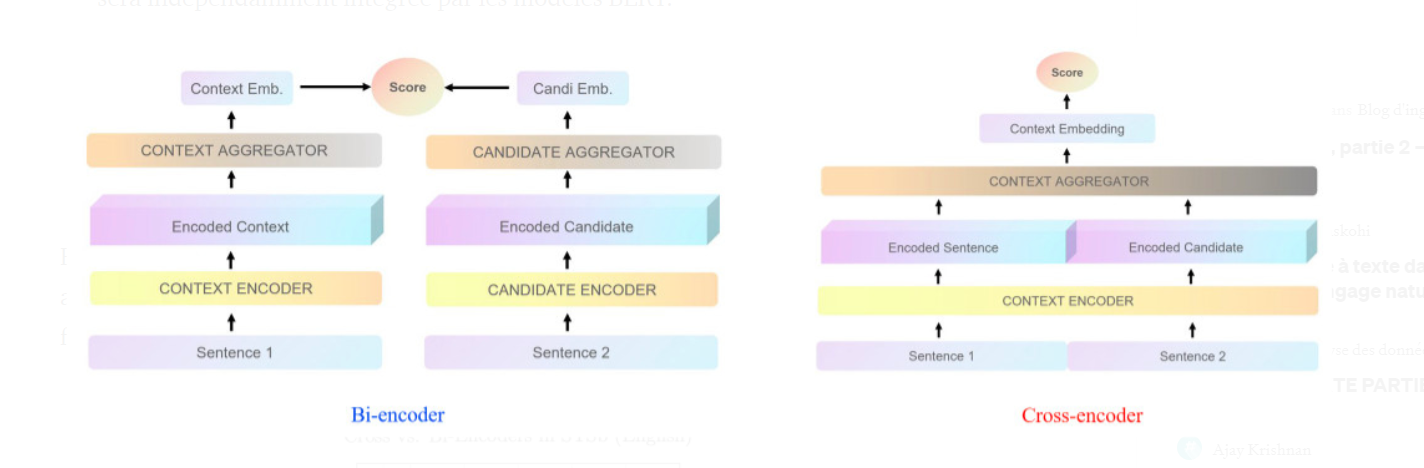

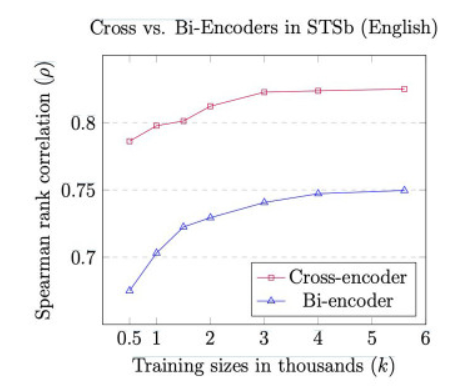

Cependant, l'utilisation finale d'un codeur croisé n'est pas pratique en raison du coût de calcul très élevé. Par exemple:

1 - Le regroupement de 10 000 phrases a une complexité quadratique avec un codeur croisé et nécessiterait environ 65 heures de formation avec BERT.

2 - La récupération d'informations de bout en bout n'est pas non plus possible avec les codeurs croisés car ils ne produisent pas de représentations indépendantes pour les entrées qui pourraient être indexées.

# Entraînement avec Data Augmentation à l'aide d'un Cross-Encoder.

Tout d'abord, nous nous entraînons sur le même ensemble de données STSBenchmark-french avec un modèle Cross-encoder, où une attention totale est appliquée sur les paires de phrases d'entrée (au lieu que chaque phrase utilise indépendamment le Bi-encoder), et où la sortie est leur score de cosinus de similarité correspondant ( entre 0 et 1).

En raison de ces contraintes pratiques, nous avons décidé d'exploiter les avantages des deux modèles. Le modèle final qui sera utilisé pour donner des Embeddings (vecteurs) à comparer sera un Bi-encodeur

# Étape 1 : Entraîner le modèle multicodeur avec l'ensemble de données STSbenchmark

Lors de la préparation de l'ensemble de données, nous allons échanger les positions de chaque paire de phrases dans l'ensemble d'apprentissage et les ajouter à l' ensemble d'apprentissage précédent (illustré à la figure 7) tout en gardant l'ensemble de test et l' ensemble de développement inchangés.

Cette stratégie simple double le nombre d'échantillons d'apprentissage utilisés pour l'apprentissage du codeur croisé. Nous appelons cet ensemble de données augmenté « Échantillons d'or ».

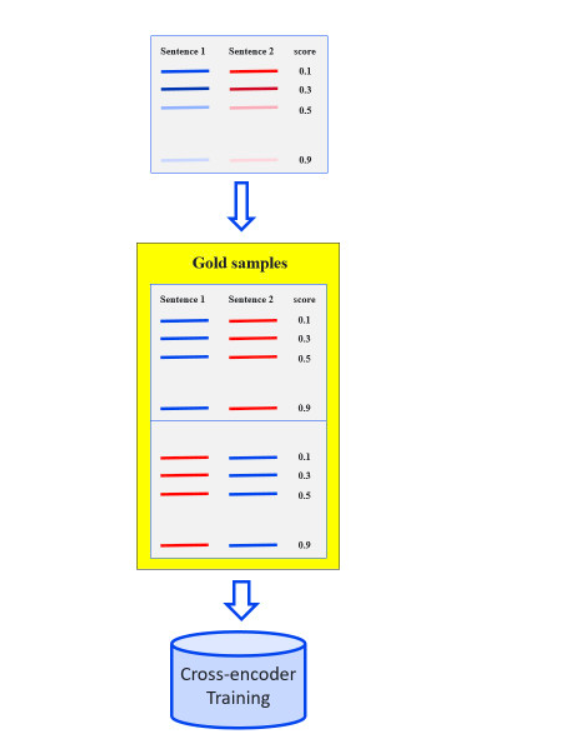

In [ ]:
!pip install sentence-transformers -q
!pip install datasets -q

     |████████████████████████████████| 79 kB 1.3 MB/s 
     |████████████████████████████████| 4.2 MB 32.0 MB/s 
     |████████████████████████████████| 1.2 MB 48.1 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 6.6 MB 44.9 MB/s 
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 212 kB 60.4 MB/s 
     |████████████████████████████████| 140 kB 63.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
     |████████████████████████████████| 127 kB 67.6 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 72.9 MB/s 
     |████████████████████████████████| 144 kB 53.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [ ]:
from datasets import load_dataset
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
from sentence_transformers import SentenceTransformer,  models, util
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader


def convert_dataset(dataset):
    dataset_samples=[]
    for df in dataset:
        score = float(df['similarity_score'])/5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[df['sentence1'], 
                                    df['sentence2']], label=score)
        dataset_samples.append(inp_example)
    return dataset_samples
    
train_samples = convert_dataset(df_train)
dev_samples = convert_dataset(df_valid)
test_samples = convert_dataset(df_test)

In [ ]:
gold_samples = []
batch_size = 16
for df in df_train:
    score = float(df['similarity_score'])/5.0  # Normalize score to range 0 ... 1
    gold_samples.append(InputExample(texts=[df['sentence1'], df['sentence2']], label=score))
    gold_samples.append(InputExample(texts=[df['sentence2'], df['sentence1']], label=score))
# We wrap gold_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=batch_size)

Ensuite, nous chargeons le modèle Cross-encoder pré-formé à partir de la bibliothèque sentence_transformers

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers import SentenceTransformer,  models, util
from datetime import datetime
import math
import logging
num_epochs = 10
model_name = "camembert/camembert-large"
cross_encoder_path = 'output/cross-encoder/stsb_indomain_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

###### Cross-encoder (simpletransformers) ######
logging.info("Loading cross-encoder model: {}".format(model_name))
# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for cross-encoder model
cross_encoder = CrossEncoder(model_name, num_labels=1)

Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert/camembert-large were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['cl

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Ensuite, nous définissons l'évaluation de l'ensemble de développement pendant la formation par :

In [ ]:
# We add an evaluator, which evaluates the performance during training
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev', write_csv = True)

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

Model training

In [ ]:
# Train the cross-encoder model
cross_encoder.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          #epochs=num_epochs,
          epochs= num_epochs,
          evaluation_steps=1000,
          optimizer_params={'lr': 1e-5, 
                            'eps': 1e-6, 
                            'correct_bias': False},
          warmup_steps=warmup_steps,
          output_path=cross_encoder_path)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Save Cross Encoder Model

In [ ]:
import torch
cross_encoder_camembert = CrossEncoder(cross_encoder_path)
torch.save(cross_encoder_camembert, "/content/drive/MyDrive/cross_encoder_camembert_similarity.pth")

#cross_encoder_camembert.save(path="/content/drive/MyDrive/", model_name='mehdi', create_model_card=True)

In [ ]:
# All metrics for validation data in each epoch
import pandas as pd
valid_metrics = pd.read_csv("/content/output/cross-encoder/stsb_indomain_camembert-camembert-large-2022-05-30_23-34-20/CECorrelationEvaluator_sts-dev_results.csv")
valid_metrics

,epoch,steps,Pearson_Correlation,Spearman_Correlation
0,0,-1,0.892512,0.891310
1,1,-1,0.893031,0.895260
2,2,-1,0.901135,0.900446
3,3,-1,0.900405,0.898184
4,4,-1,0.901047,0.899572
5,5,-1,0.900581,0.899047
6,6,-1,0.899117,0.897794
7,7,-1,0.900055,0.898742
8,8,-1,0.900917,0.899521
9,9,-1,0.900882,0.899569


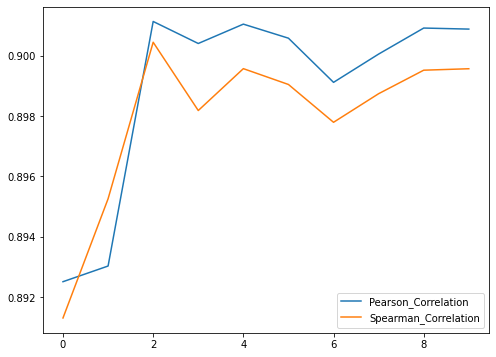

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(valid_metrics['epoch'], valid_metrics["Pearson_Correlation"], label="Pearson_Correlation")
plt.plot(valid_metrics['epoch'], valid_metrics["Spearman_Correlation"], label ='Spearman_Correlation')


plt.legend()
plt.show() 

In [ ]:
#Performance on test data
test_evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test', write_csv = True)
test_evaluator(cross_encoder, output_path=cross_encoder_path)

0.8777987473286816

In [ ]:
# All Metrics for test data
test_metrics = pd.read_csv("/content/output/cross-encoder/stsb_indomain_camembert-camembert-large-2022-05-30_23-34-20/CECorrelationEvaluator_sts-test_results.csv")
test_metrics

,epoch,steps,Pearson_Correlation,Spearman_Correlation
0,-1,-1,0.883849,0.877799


In [ ]:
# Performance on validation data
dev_evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev', write_csv = True)
dev_evaluator(cross_encoder, output_path=cross_encoder_path)

0.8995686501613571

In [ ]:
#Performance on train data
train_evaluator = CECorrelationEvaluator.from_input_examples(train_samples, name='sts-train', write_csv = True)
train_evaluator(cross_encoder, output_path=cross_encoder_path)


0.9841472013197043

In [ ]:
# All Metrics for test data
train_metrics = pd.read_csv("/content/output/cross-encoder/stsb_indomain_camembert-camembert-large-2022-05-30_23-34-20/CECorrelationEvaluator_sts-train_results.csv")
train_metrics

,epoch,steps,Pearson_Correlation,Spearman_Correlation
0,-1,-1,0.996477,0.996533


## Étape 2 : Construisez des paires d'argent et marquez-les à l'aide de l'encodeur croisé

En utilisant les échantillons Gold et le Cross-encoder préalablement formé, nous générons des paires appelées échantillons Silver ou paires Silver.

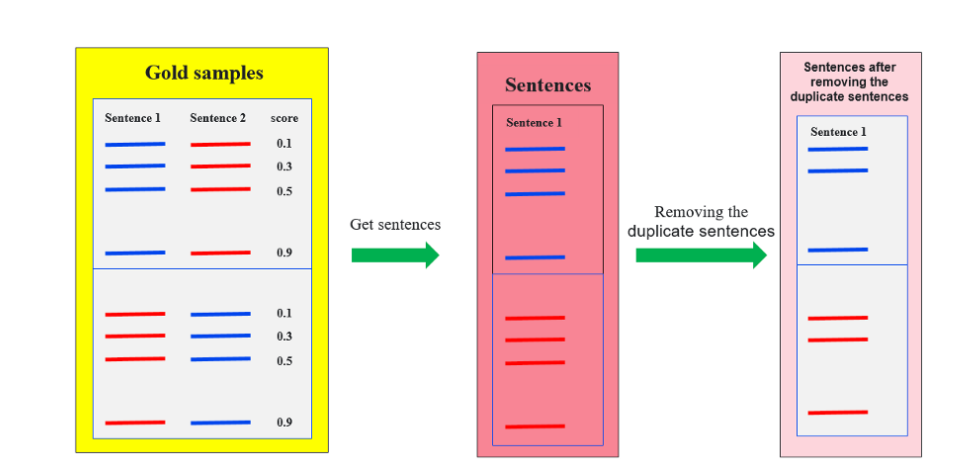

Nous ne prenons qu'une seule colonne de phrases (la première phrase des paires par exemple) à partir du gold sample et supprimons les phrases en double. Nous obtenons un ensemble de données contenant des phrases uniques à partir de l'ensemble de données gold.

In [ ]:
# Generation of the sentences
sentences = set()

for sample in gold_samples:
    sentences.update(sample.texts)

sentences = list(sentences) # unique sentences
sent2idx = {sentence: idx for idx, sentence in enumerate(sentences)} # storing id and sentence in dictionary
duplicates = set((sent2idx[data.texts[0]], sent2idx[data.texts[1]]) for data in gold_samples) # not to include gold pairs of sentences again"""


Après cette étape, nous calculons la similarité cosinus de chaque phrase avec le reste des phrases de cet ensemble.

Ce que nous faisons à la place, c'est :

*   Utilisez le modèle Bi-encodeur formé dans la phase 1 pour encoder les N phrases.

*  Calculer le score de similarité cosinus conventionnel ( N x N-1 fois mais c'est juste un calcul normal, c'est rapide)
*  Ne retenez que les top-k phrases similaires, pour chaque phrase. (obtenant ainsi N xk paire de phrases)


*  Ces N xk échantillons seront appelés "Silver samples"




In [ ]:
# Load the bi-encoder model which is trained in Phase 1
import tqdm
import sys
import torch
"""semantic_search_model = load_model("camembert_sts/sentence_camembert")
logging.info("Encoding unique sentences with semantic search model: {}".format(semantic_model_name))"""

#semantic_model_name = 'dangvantuan/sentence-camembert-large'
#semantic_search_model = SentenceTransformer(semantic_model_name)

#### load model 
semantic_search_model = torch.load('/content/drive/MyDrive/bi_encoder_camembert_similarity.pth')


top_k = 2

# encoding all unique sentences present in the training dataset
embeddings = semantic_search_model.encode(sentences, batch_size=batch_size, convert_to_tensor=True)

logging.info("Retrieve top-{} with semantic search model: {}".format(top_k, semantic_search_model))

# retrieving top-k sentences given a sentence from the dataset
top_k=2
silver_data = []
progress = tqdm.tqdm(unit="docs", total=len(sent2idx))
for idx in range(len(sentences)):
    sentence_embedding = embeddings[idx]
    cos_scores = util.cos_sim(sentence_embedding, embeddings)[0]
    cos_scores = cos_scores.cpu()
    progress.update(1)

    # We use torch.topk to find the highest 5 scores
    top_results = torch.topk(cos_scores, k=top_k+1)
    
    for score, iid in zip(top_results[0], top_results[1]):
        if iid != idx and (iid, idx) not in duplicates:
            silver_data.append((sentences[idx], sentences[iid]))
            duplicates.add((idx,iid))            
progress.reset()
progress.close()

  0%|          | 0/10383 [00:00<?, ?docs/s]


Nous utilisons ensuite l'encodeur croisé formé (étape 1) pour étiqueter (score, un score de qualité supérieure cette fois) pour les paires de phrases argentées. ( Une sorte de Re-Ranking )

In [ ]:
import torch
cross_encoder = torch.load("/content/drive/MyDrive/cross_encoder_camembert_similarity.pth")

In [ ]:
logging.info("Length of silver_dataset generated: {}".format(len(silver_data)))
logging.info("Step 2.2: Label STSbenchmark (silver dataset) with cross-encoder: {}".format(model_name))
#cross_encoder = CrossEncoder(cross_encoder_path)
silver_scores = cross_encoder.predict(silver_data)

# All model predictions should be between [0,1]
assert all(0.0 <= score <= 1.0 for score in silver_scores)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### **Étape 3 : Entraînez un modèle Bi-encodeur sur l'ensemble de données, y compris les échantillons Gold et Silver**

Après avoir créé les paires de phrases dans les échantillons Silver à l'aide du modèle Bi-encoder formé de Phase 1 et les avoir étiquetées à l'aide du Cross-Encoder formé dans la phase précedente , nous combinons les échantillons Gold et les échantillons Silver pour entraîner un nouveau Bi-encodeur.

In [ ]:
# Combine Gold samples and Silver samples then convert for training
logging.info("Step 3: Train bi-encoder: {} with STSbenchmark (gold + silver dataset)".format(model_name))

# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark gold and silver train dataset")
silver_samples = list(InputExample(texts=[data[0], data[1]], label=score) for \
    data, score in zip(silver_data, silver_scores))
train_dataloader = DataLoader(gold_samples + silver_samples, shuffle=True, batch_size=batch_size)

## /////// Nous définissons train_loss et evaluator pour le nouveau modèle  Bi-Encoder

Bi-encoder applied on augmented data

In [ ]:
from sentence_transformers import SentenceTransformer,  models, util
from datetime import datetime

bi_encoder_path = 'output/New_Bi-Encoder_training_stsbenchmark_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
batch_size = 16
num_epochs = 10
max_seq_length = 128


# Use Huggingface/transformers CamemBERT model for mapping tokens to embeddings
model_name =  "camembert/camembert-large"

###### Bi-encoder (sentence-transformers) ######
logging.info("Loading bi-encoder model: {}".format(model_name))
# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at camembert/camembert-large were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = 'cuda'
import torch, gc
import os
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from sentence_transformers import losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

train_loss = losses.CosineSimilarityLoss(model=bi_encoder)
logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev', write_csv = True)

# Configure the training.
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))
# Train the bi-encoder model

bi_encoder.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          optimizer_params={'lr': 1e-5, 
                            'eps': 1e-6, 
                            'correct_bias': False},
          save_best_model = True,
          warmup_steps=warmup_steps,
          output_path=bi_encoder_path)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2017 [00:00<?, ?it/s]

In [ ]:
import torch
bi_encoder_AugCamembert= SentenceTransformer(bi_encoder_path)
torch.save(bi_encoder_AugCamembert, "/content/drive/MyDrive/BiEncoder_AugCamembert_similarityV2.pth")

In [ ]:
import pandas as pd
valid_metrics = pd.read_csv("/content/output/New_Bi-Encoder_training_stsbenchmark_camembert-camembert-large-2022-05-31_14-38-52/eval/similarity_evaluation_sts-dev_results.csv")
valid_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,1000,0.865110,0.863119,0.845877,0.847463,0.844956,0.846634,0.773568,0.776014
1,0,2000,0.874020,0.872095,0.848684,0.852463,0.848352,0.851955,0.800146,0.805639
2,0,-1,0.868974,0.866495,0.845891,0.848357,0.845516,0.847893,0.794853,0.801561
3,1,1000,0.879611,0.877234,0.856306,0.859995,0.855759,0.859413,0.808418,0.815248
4,1,2000,0.876498,0.874240,0.859988,0.862519,0.859289,0.861902,0.830049,0.832006
5,1,-1,0.877435,0.874804,0.859516,0.862739,0.858910,0.862127,0.828673,0.830724
6,2,1000,0.878704,0.876490,0.860395,0.863179,0.860112,0.862907,0.831367,0.832717
7,2,2000,0.877340,0.875276,0.857709,0.861138,0.857105,0.860402,0.835022,0.836483
8,2,-1,0.876543,0.874362,0.857817,0.861792,0.857257,0.861170,0.834922,0.837099
9,3,1000,0.880093,0.877764,0.858664,0.863404,0.858023,0.862433,0.835827,0.838223


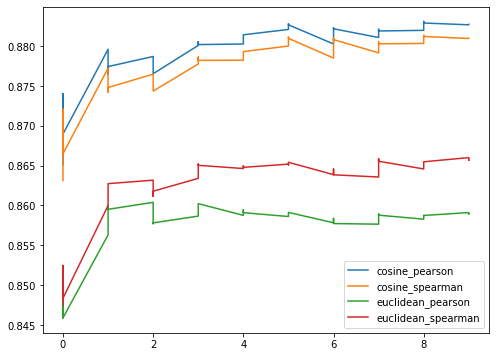

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(valid_metrics['epoch'], valid_metrics["cosine_pearson"], label="cosine_pearson")
plt.plot(valid_metrics['epoch'], valid_metrics["cosine_spearman"], label ='cosine_spearman')

plt.plot(valid_metrics['epoch'], valid_metrics["euclidean_pearson"], label="euclidean_pearson")
plt.plot(valid_metrics['epoch'], valid_metrics["euclidean_spearman"], label ='euclidean_spearman')

plt.legend()
plt.show() 

In [ ]:
#################################################################################
#
# Evaluate cross-encoder and Augmented SBERT performance on STS benchmark dataset
#
#################################################################################

# Performance on test data
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test', write_csv = True)
test_evaluator(bi_encoder, output_path=bi_encoder_path)

0.8586993557260179

In [ ]:
# All Metrics for test data
test_metrics = pd.read_csv("/content/output/New_Bi-Encoder_training_stsbenchmark_camembert-camembert-large-2022-05-31_14-38-52/similarity_evaluation_sts-test_results.csv")
test_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.859729,0.858699,0.838943,0.844688,0.838597,0.844303,0.812525,0.807769


In [ ]:
# Performance on validation data
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev', write_csv = True)
dev_evaluator(bi_encoder, output_path=bi_encoder_path)

0.880982576525801

In [ ]:
# All metrics for validation data
dev_metrics = pd.read_csv("/content/output/New_Bi-Encoder_training_stsbenchmark_camembert-camembert-large-2022-05-31_14-38-52/similarity_evaluation_sts-dev_results.csv")
dev_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.882745,0.880983,0.858931,0.865669,0.85826,0.86476,0.838434,0.842513


In [ ]:
# Performance on train data
train_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(train_samples, name='sts-train', write_csv = True)
train_evaluator(bi_encoder_AugCamembert, output_path=bi_encoder_path)

0.9936108072149366

In [ ]:
# All metrics for train data
train_metrics = pd.read_csv("/content/output/New_Bi-Encoder_training_stsbenchmark_camembert-camembert-large-2022-05-31_14-38-52/similarity_evaluation_sts-train_results.csv")
train_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.993724,0.993611,0.969726,0.978541,0.969554,0.978287,0.948941,0.947978


In [ ]:
# All metics for all data with best model 
metrics = pd.concat([train_metrics,dev_metrics], axis=0)
metrics = pd.concat([metrics, test_metrics], axis=0)
metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.993724,0.993611,0.969726,0.978541,0.969554,0.978287,0.948941,0.947978
0,-1,-1,0.882745,0.880983,0.858931,0.865669,0.858260,0.864760,0.838434,0.842513
0,-1,-1,0.859729,0.858699,0.838943,0.844688,0.838597,0.844303,0.812525,0.807769


In [ ]:
# Save All
bi_encoder_AugCamembert.save(path="/content/drive/MyDrive/bi_encoder_AugCamembertV2", model_name='bi_encoder_AugCamembertV2', create_model_card=True)